<img src="./sharif.png" alt="SUT logo" width=300 height=300 align=left class="saturate">

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3<br>
<font color=696880 size=4>
    Ashkan Majidi - Shayan Salehi - Amirhossein Alamdar

____

# Personal Data

In [ ]:
student_number = '98100561'
first_name = 'Soheil'
last_name = 'Homayoonfard'

: 

# Introduction

In this assignment, you will implement SVM (Support Vector Machines) for classification.


# Data Prepfocessing

Import your needed libraries in following cell.

In [ ]:
import copy
import cvxopt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.svm import SVC
from scipy.spatial import distance
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

: 

Load data from ```satimage``` dataset and split data to features and labels. The ```label``` column is our target variable.

In [3]:
# Load the dataset
data = pd.read_csv("satimage.csv")
data['label'].unique()

# Split the data into features (X) and labels (y)
data = data[(data['label'] == 4) | (data['label'] == 6)]
X = data.drop(['label'], axis=1).values
y = data['label'].values

# Check the shape of X and y
print("Shape of features (X):", X.shape)
print("Shape of labels (y):", y.shape)

Shape of features (X): (2134, 36)
Shape of labels (y): (2134,)


Now split data to train, validation and test parts. 60% of data should be used for train, 15% for validation and 25% for test. After that scale the data to Standard Normal Distribution using ```StandardScaler``` class from ```scikit-learn``` library.

In [4]:
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.625)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

# Check the shapes of the datasets after splitting and scaling
print("Shape of X_train_scaled:", X_train.shape)
print("Shape of X_val_scaled:", X_val.shape)
print("Shape of X_test_scaled:", X_test.shape)

Shape of X_train_scaled: (1280, 36)
Shape of X_val_scaled: (320, 36)
Shape of X_test_scaled: (534, 36)


We want to train Binary SVM model for classification between labels 4 and 6. Choose corresponding datas and convert their lables to 1 and -1 respectively for 4 and 6.

In [5]:
# Convert labels 4 to 1 and 6 to -1
y_train = np.where(y_train == 4, 1, -1)
y_val = np.where(y_val == 4, 1, -1)
y_test = np.where(y_test == 4, 1, -1)

# Check the shapes of the binary datasets after filtering and converting labels
print("Shape of y_train_binary:", y_train.shape)
print("Shape of y_val_binary:", y_val.shape)
print("Shape of y_test_binary:", y_test.shape)

Shape of y_train_binary: (1280,)
Shape of y_val_binary: (320,)
Shape of y_test_binary: (534,)


# Model (50 points)

Here is soft margin svm convex optimization formulation.
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2}\|\mathbf{w}\|^2+C \sum_{i=1}^N \xi_i \\
\text { Subject to } & y_i\left(\mathbf{w}^T \mathbf{x}_i+b\right) \geq 1-\xi_i, \quad i=1,2, \ldots, N \\
& \xi_i \geq 0, \quad i=1,2, \ldots, N
\end{aligned}
$$


write dual of the soft margin svm optimization problem below:

$$
\text{Maximize}\ \ \sum_{n=1}^{N}\alpha_n-\frac{1}{2}\sum_{n=1}^{N}\sum_{m=1}^{N}
\alpha_n\alpha_my^{(n)}y^{(m)}x^{{(n)}^T}x^{(m)}
$$
$$
\text{s.t.}
\begin{cases}
    \sum\limits_{n=1}^{N}\alpha_ny^{(n)}=0 \\
    0\leq\alpha_n\leq C & n=1,\dots,N
\end{cases}
$$

Now you should write this optimization problem in standard Quadratic Program (QP) form and use a QP solver to find optimal answer. Here is General form of a QP:
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2} x^TPx + q^Tx + r \\
\text { Subject to } & Gx \leq h \\
& Ax = b
\end{aligned}
$$

Complete functions below and use ```cvxopt``` library which is a common library for solving QPs. Note that you can't use ```scikit-learn``` library.


In [6]:
def soft_margin_svm(X, y, C):

    n_samples, n_features = X.shape

    # Gram matrix
    K = np.dot(X, X.T)

    # P, q, G, h, A, b matrices for cvxopt
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(-np.ones(n_samples))
    G = cvxopt.matrix(np.vstack((np.eye(n_samples) * -1, np.eye(n_samples))))
    h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    A = cvxopt.matrix(y, (1, n_samples), 'd')
    b = cvxopt.matrix(0.0)

    # Solve QP problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # Lagrange multipliers
    alphas = np.array(solution['x']).flatten()

    # Support vectors have non-zero lagrange multipliers
    sv = (alphas > 1e-5)
    ind = np.arange(len(alphas))[sv]
    support_vectors = X[sv]
    support_vector_labels = y[sv]
    support_vector_alphas = alphas[sv]

    return support_vectors, support_vector_labels, support_vector_alphas

In [7]:
C = 1.0
support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(X_train, y_train, C)

     pcost       dcost       gap    pres   dres
 0: -6.0333e+02 -3.4454e+03  2e+04  3e+00  6e-13
 1: -4.1178e+02 -2.3433e+03  3e+03  4e-01  5e-13
 2: -3.7754e+02 -7.7981e+02  5e+02  3e-02  4e-13
 3: -4.1948e+02 -5.4905e+02  1e+02  8e-03  4e-13
 4: -4.3471e+02 -5.1686e+02  9e+01  4e-03  4e-13
 5: -4.4565e+02 -4.9432e+02  5e+01  2e-03  3e-13
 6: -4.5415e+02 -4.7739e+02  2e+01  6e-04  4e-13
 7: -4.5821e+02 -4.7051e+02  1e+01  2e-04  4e-13
 8: -4.6113e+02 -4.6592e+02  5e+00  6e-05  4e-13
 9: -4.6247e+02 -4.6400e+02  2e+00  1e-05  4e-13
10: -4.6293e+02 -4.6342e+02  5e-01  3e-06  4e-13
11: -4.6306e+02 -4.6325e+02  2e-01  8e-07  4e-13
12: -4.6313e+02 -4.6317e+02  5e-02  3e-14  5e-13
13: -4.6315e+02 -4.6315e+02  8e-03  2e-14  4e-13
14: -4.6315e+02 -4.6315e+02  4e-04  2e-14  4e-13
Optimal solution found.


In [8]:
def predict_labels(x_test, support_vectors, support_vector_labels, support_vector_alphas):
    # Calculate the kernel matrix between support vectors and test samples
    K = np.dot(support_vectors, x_test.T)

    # Calculate the decision function using the support vectors, their labels, and alphas
    decision_func = np.dot((support_vector_labels * support_vector_alphas).reshape(1, -1), K)

    # Predict the labels based on the sign of the decision function
    y_pred = np.sign(decision_func).flatten()

    return y_pred


In [9]:
y_pred = predict_labels(np.array(X_test), support_vectors, support_vector_labels, support_vector_alphas)

# Evaluation (20 points)

Compute accuracy, balanced accuracy and plot confusion matrix of your trained model using ```Seaborn.heatmap()``` function. Use case of balanced accuracy is when dealing with imbalanced data, i.e. when one of the target classes appears a lot more than the other and it is defined by average of recall of classes. Confusion matrix is a $k\times k$ (k is number of classes) matrix which cell ij is showing that number of data points labeld i which predicted j. For more detail of evaluation metrics you can see [here](https://neptune.ai/blog/balanced-accuracy).

You may use ```scikit-learn``` library to compute these metrics.

In [10]:
def evaluate(y_test, y_pred):
    # Calculate accuracy and balanced accuracy
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # Generate confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Print evaluation metrics
    print("Accuracy: ", accuracy)
    print("Balanced Accuracy: ", balanced_accuracy)
    print("Confusion Matrix:\n", confusion_mat)

    return accuracy, balanced_accuracy, confusion_mat

In [11]:
_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy:  0.7827715355805244
Balanced Accuracy:  0.8286458333333333
Confusion Matrix:
 [[278 106]
 [ 10 140]]


<Axes: >

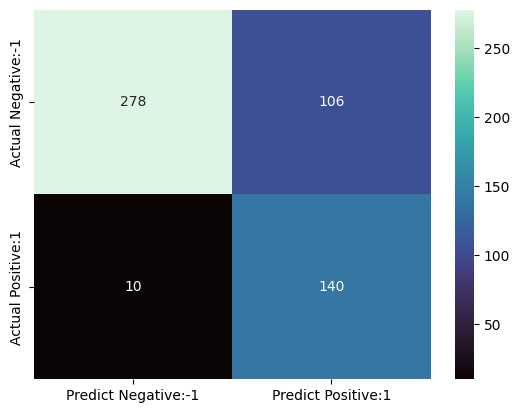

In [12]:
cm_matrix = pd.DataFrame(data=confusion_mat, columns=['Predict Negative:-1', 'Predict Positive:1'],
                                 index=['Actual Negative:-1', 'Actual Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')

# Fine-tunning (40 points)

like what you did before, implement Soft Margin SVM but now use rbf kernel. To determine rbf $\gamma$ parameter use validation datas and find best(best by balanced accuracy) $\gamma$ between 0.001 , 0.01, 1, 10, 100. Not that you can't use ```scikit-learn``` library here.

In [13]:
def rbf(x1, x2, gamma=1):
    """Compute the Radial Basis Function (RBF) kernel between two vectors."""
    diff = np.subtract(x1, x2)
    squared_norm = np.dot(diff, diff)
    return np.exp(-gamma * squared_norm)

def soft_margin_svm(X, y, C, gamma=1):
    """Train a soft-margin Support Vector Machine (SVM) using the RBF kernel."""
    n = X.shape[0]

    # Compute the RBF kernel matrix
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = rbf(X[i], X[j], gamma)

    # Define the optimization problem
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(-np.ones(n))
    G = cvxopt.matrix(np.vstack((-np.eye(n), np.eye(n))))
    h = cvxopt.matrix(np.hstack((np.zeros(n), C * np.ones(n))))
    A = cvxopt.matrix(y, (1, n), 'd')
    b = cvxopt.matrix(0.0)

    # Solve the optimization problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])

    # Extract support vectors, their labels, and corresponding alphas
    sv = (alphas > 1e-5)
    support_vectors = X[sv]
    support_vector_labels = y[sv]
    support_vector_alphas = alphas[sv]

    return support_vectors, support_vector_labels, support_vector_alphas


In [14]:
# Define the list of gamma values to explore
gammas = [0.01, 0.1, 1, 10, 100]

# Initialize variables to store the best model's parameters
best_gamma = None
best_balanced_accuracy = -1
best_support_vectors = None
best_support_vector_labels = None
best_support_vector_alphas = None

# Loop over each gamma value
for gamma in gammas:
    # Train a soft-margin SVM using the current gamma value
    support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(X_train, y_train, C, gamma)

    # Predict labels for the validation set
    y_pred = predict_labels(np.array(X_val), support_vectors, support_vector_labels, support_vector_alphas)

    # Evaluate the model's performance on the validation set
    _, ba1, _ = evaluate(y_val, y_pred)

    # Update the best model's parameters if the current model has a higher balanced accuracy
    if ba1 > best_balanced_accuracy:
        best_gamma = gamma
        best_balanced_accuracy = ba1
        best_support_vectors = support_vectors
        best_support_vector_labels = support_vector_labels
        best_support_vector_alphas = support_vector_alphas

# Print the best gamma value
print("Best gamma:", best_gamma)

     pcost       dcost       gap    pres   dres
 0: -4.6159e+02 -3.1383e+03  2e+04  3e+00  1e-14
 1: -3.2679e+02 -1.9760e+03  2e+03  2e-01  8e-15
 2: -3.4110e+02 -6.4505e+02  3e+02  2e-02  7e-15
 3: -3.8469e+02 -4.9276e+02  1e+02  6e-03  7e-15
 4: -4.0190e+02 -4.5422e+02  5e+01  2e-03  8e-15
 5: -4.0999e+02 -4.3762e+02  3e+01  9e-04  7e-15
 6: -4.1706e+02 -4.2408e+02  7e+00  2e-04  8e-15
 7: -4.1889e+02 -4.2104e+02  2e+00  3e-05  8e-15
 8: -4.1971e+02 -4.1989e+02  2e-01  2e-06  8e-15
 9: -4.1979e+02 -4.1980e+02  1e-02  9e-08  8e-15
10: -4.1979e+02 -4.1979e+02  2e-04  2e-09  9e-15
Optimal solution found.
Accuracy:  0.796875
Balanced Accuracy:  0.8309601960149785
Confusion Matrix:
 [[166  57]
 [  8  89]]
     pcost       dcost       gap    pres   dres
 0: -2.4464e+02 -2.5255e+03  1e+04  2e+00  2e-15
 1: -1.9884e+02 -1.4271e+03  1e+03  1e-01  1e-15
 2: -2.1675e+02 -4.4274e+02  2e+02  2e-02  1e-15
 3: -2.4005e+02 -3.0562e+02  7e+01  2e-03  1e-15
 4: -2.4925e+02 -2.6917e+02  2e+01  4e-04  1

In [15]:
y_pred = predict_labels(np.array(X_test), best_support_vectors, best_support_vector_labels, best_support_vector_alphas)
_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy:  0.7846441947565543
Balanced Accuracy:  0.8360416666666667
Confusion Matrix:
 [[276 108]
 [  7 143]]


# Multiclass SVM (30 points + 50 points optional)

Now we want implement Multiclass SVM. Use ```SVC``` function with rbf kernel from ```scikit-learn``` package on all train datas (all six classes) and choose best hyperparameters for $C$ and $\gamma$ between 0.01, 0.1, 1, 10, 100. After that evaluate it with your function.

Note that in this example we had enough data to split them in train and validation but in case that we don't have enough data, ```scikit-learn``` has a built-in fast library named ```GridSearchCV()``` which can help us in hyperparameter tunning with cross validation.

In [16]:
# Load the dataset from CSV file
data = pd.read_csv('satimage.csv')

# Extract features (X) and target labels (y)
X = data.drop(['label'], axis=1).values
y = data['label'].values

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.625)

# Standardize features using scaler (assuming 'scaler' is already defined)
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

In [17]:
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.01, 0.1, 1, 10, 100]

def evaluate(y_true, y_pred):
    """Evaluate the performance of a classifier."""
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    confusion_mat = confusion_matrix(y_true, y_pred)
    print("Accuracy:", accuracy)
    print("Balanced Accuracy:", balanced_accuracy)
    print("Confusion Matrix:\n", confusion_mat)
    return accuracy, balanced_accuracy, confusion_mat

In [18]:
# Create the parameter grid
param_grid = {'C': Cs, 'gamma': gammas}

# Create the GridSearchCV object
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')

# Train the model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']

# Print the best hyperparameters
print("Best C:", best_C)
print("Best Gamma:", best_gamma)

# Predict labels on test data using the model with best hyperparameters
y_pred = grid_search.predict(X_test)

# Evaluate the model
evaluate(y_test, y_pred)

Best C: 10
Best Gamma: 0.1
Accuracy: 0.9129894344313239
Balanced Accuracy: 0.8913489179849763
Confusion Matrix:
 [[358   0   2   0   1   0]
 [  0 175   0   0   5   1]
 [  5   3 337  13   0   8]
 [  0   3  32  90   3  13]
 [  1   2   2   2 166   5]
 [  0   0   5  27   7 343]]


(0.9129894344313239,
 0.8913489179849763,
 array([[358,   0,   2,   0,   1,   0],
        [  0, 175,   0,   0,   5,   1],
        [  5,   3, 337,  13,   0,   8],
        [  0,   3,  32,  90,   3,  13],
        [  1,   2,   2,   2, 166,   5],
        [  0,   0,   5,  27,   7, 343]]))

Implement Multiclass SVM from scratch without using ready functions (optional).

In [19]:
class SVM:
    # Define kernel functions as lambda functions
    linear = lambda x, x_, c=0: x @ x_.T
    polynomial = lambda x, x_, Q=5: (1 + x @ x_.T)**Q
    rbf = lambda x, x_, gamma=10: np.exp(-gamma * distance.cdist(x, x_,'sqeuclidean'))

    # Dictionary to map kernel names to kernel functions
    kernel_funs = {'linear': linear, 'polynomial': polynomial, 'rbf': rbf}

    def __init__(self, kernel='rbf', C=1, k=2):
        """Initialize the SVM model with hyperparameters."""
        # Set the hyperparameters
        self.kernel_str = kernel
        self.kernel = SVM.kernel_funs[kernel]  # Select kernel function based on the kernel name
        self.C = C  # Regularization parameter
        self.k = k  # Number of classes for multi-class classification

        # Training data and support vectors
        self.X, self.y = None, None  # Training data
        self.alphas = None  # Lagrange multipliers

        # For multi-class classification
        self.multiclass = False  # Flag to indicate multi-class classification
        self.clfs = []  # List to store binary classifiers for multi-class

    def fit(self, X, y):
        """Fit the SVM model to the training data."""
        # Multi-class classification
        if len(np.unique(y)) > 2:
            self.multiclass = True
            return self.multi_fit(X, y)

        # Relabel if needed
        if set(np.unique(y)) == {0, 1}:
            y[y == 0] = -1

        # Ensure y has dimensions Nx1
        self.y = y.reshape(-1, 1).astype(np.double)
        self.X = X
        N = X.shape[0]

        # Compute the kernel matrix over all possible pairs of (x, x') in the data
        self.K = self.kernel(X, X, self.k)

        # Define the optimization problem
        P = cvxopt.matrix(self.y @ self.y.T * self.K)
        q = cvxopt.matrix(-np.ones((N, 1)))
        A = cvxopt.matrix(self.y.T)
        b = cvxopt.matrix(np.zeros(1))
        G = cvxopt.matrix(np.vstack((-np.identity(N), np.identity(N))))
        h = cvxopt.matrix(np.vstack((np.zeros((N,1)), np.ones((N,1)) * self.C)))

        # Solve the optimization problem
        cvxopt.solvers.options['show_progress'] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol["x"])

        # Map support vectors
        self.is_sv = ((self.alphas > 1e-3) & (self.alphas <= self.C)).squeeze()
        self.margin_sv = np.argmax((1e-3 < self.alphas) & (self.alphas < self.C - 1e-3))

    def multi_fit(self, X, y):
        """Fit the SVM model for multi-class classification."""
        self.k = len(np.unique(y))
        for i in range(self.k):
            Xs, Ys = X, copy.copy(y)
            Ys[Ys!=i], Ys[Ys==i] = -1, +1
            clf = SVM(kernel=self.kernel_str, C=self.C, k=self.k)
            clf.fit(Xs, Ys)
            self.clfs.append(clf)

    def predict(self, X_t):
        """Predict labels for test data."""
        if self.multiclass:
            return self.multi_predict(X_t)

        xₛ, yₛ = self.X[self.margin_sv, np.newaxis], self.y[self.margin_sv]
        alphas, y, X= self.alphas[self.is_sv], self.y[self.is_sv], self.X[self.is_sv]

        b = yₛ - np.sum(alphas * y * self.kernel(X, xₛ, self.k), axis=0)
        score = np.sum(alphas * y * self.kernel(X, X_t, self.k), axis=0) + b
        return np.sign(score).astype(int), score

    def multi_predict(self, X):
        """Predict labels for test data in multi-class setting."""
        preds = np.zeros((X.shape[0], self.k))
        for i, clf in enumerate(self.clfs):
            _, preds[:, i] = clf.predict(X)
        return np.argmax(preds, axis=1)

    def evaluate(self, X, y):
        """Evaluate the performance of the SVM model."""
        outputs, _ = self.predict(X)
        accuracy = np.sum(outputs == y) / len(y)
        return round(accuracy, 2)

In [20]:
# Initialize an SVM object with k=6 for multi-class classification
my_svm = SVM(k=6)

# Fit the SVM model to the training data
my_svm.fit(X_train, y_train)

# Predict labels for the test data using multi-class prediction
y_pred = my_svm.multi_predict(X_test)

# Evaluate the performance of the SVM model
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("Confusion Matrix:\n", confusion_mat)

Accuracy: 0.22995649471721566
Balanced Accuracy: 0.17076502732240437
Confusion Matrix:
 [[361   0   0   0   0   0]
 [181   0   0   0   0   0]
 [357   0   9   0   0   0]
 [140   0   1   0   0   0]
 [178   0   0   0   0   0]
 [382   0   0   0   0   0]]


# Different SVM Kernels (40 points)

A kernel in SVM is like a tool that helps solve tricky problems. It lets us work in a space with many dimensions, making complex calculations easier. With kernels, we can deal with lots of dimensions, even an endless amount. Kernels are crucial for sorting data into groups and help spot patterns in the data we're looking at. They're especially good at tackling twisty problems with a straightforward approach.

Sometimes, finding a straight line or flat surface to divide data isn't possible, especially as we explore more dimensions. That's where different types of SVM kernels come in handy. They transform twisty, complicated data into a simpler form that's easier to separate. In this explanation, we talk about 4 popular types of these kernels. Also in following cells you can use any package.

<img src="./kernel.jpg" alt="Types of Kernel Functions"  align=center class="saturate">

### Linear Kernel

This is the simplest kind of kernel, typically working in one dimension. It works best when dealing with a lot of features. Linear kernels are quicker than other types.

**Formula:**

$$F(x, x_j) = sum(x, x_j)$$

Now Implement svc classifier using a linear kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix by `Seaborn`.

In [21]:
C = 10  # Set the value of C

# Initialize a linear SVM classifier with the specified C value
svc_linear = SVC(kernel='linear', C=C)

# Fit the SVM model to the training data
svc_linear.fit(X_train, y_train)

# Predict labels for the test data
y_pred = svc_linear.predict(X_test)

# Evaluate the performance of the SVM model using the evaluate function
_, _, confusion_mat = evaluate(y_test, y_pred)


Accuracy: 0.8669981354878806
Balanced Accuracy: 0.8295360951576113
Confusion Matrix:
 [[358   0   2   0   1   0]
 [  1 167   0   0  13   0]
 [  4   0 338  22   0   2]
 [  0   1  35  71   4  30]
 [  5   5   0   4 143  21]
 [  0   0   5  44  15 318]]


### Gaussian RBF kernel

This kernel is a favorite choice in SVM, especially for data that doesn't line up straight. It's great for sorting data when you don't know much about it beforehand.

**Formula:**

$$F(x, x_j) = \exp{(-\gamma ||x - xj||^2)}$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous part.

In [22]:
C = 10  # Set the value of C
gamma = 0.1  # Set the value of gamma

# Initialize an SVM classifier with RBF kernel, specified C, and gamma values
svc_rbf = SVC(kernel='rbf', C=C, gamma=gamma)

# Fit the SVM model to the training data
svc_rbf.fit(X_train, y_train)

# Predict labels for the test data
y_pred = svc_rbf.predict(X_test)

# Evaluate the performance of the SVM model using the evaluate function
_, _, confusion_mat = evaluate(y_test, y_pred)


Accuracy: 0.9129894344313239
Balanced Accuracy: 0.8913489179849763
Confusion Matrix:
 [[358   0   2   0   1   0]
 [  0 175   0   0   5   1]
 [  5   3 337  13   0   8]
 [  0   3  32  90   3  13]
 [  1   2   2   2 166   5]
 [  0   0   5  27   7 343]]


### Polynomial Kernel

This is a broader version of the linear kernel. It's not as popular because it's not as quick or precise.

**Formula:**

$$F(x, x_j) = (x.x_j+1)^d$$

Now, set up the SVC classifier using a *polynomial* kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts.

In [23]:
C = 10  # Set the value of C
degree = 6  # Set the degree of the polynomial kernel
coef0 = 1  # Set the coefficient for the polynomial kernel

# Initialize an SVM classifier with polynomial kernel, specified C, degree, and coef0 values
svc_poly = SVC(kernel='poly', C=C, degree=degree, coef0=coef0)

# Fit the SVM model to the training data
svc_poly.fit(X_train, y_train)

# Predict labels for the test data
y_pred = svc_poly.predict(X_test)

# Evaluate the performance of the SVM model using the evaluate function
_, _, confusion_mat = evaluate(y_test, y_pred)


Accuracy: 0.889372280919826
Balanced Accuracy: 0.8728750664413464
Confusion Matrix:
 [[357   0   2   0   2   0]
 [  1 172   0   2   6   0]
 [  9   0 329  18   0  10]
 [  1   3  29  93   2  13]
 [  1   1   1   2 161  12]
 [  0   1   6  46  10 319]]


### Sigmoid Kernel

This is mainly chosen for use with neural networks. The kernel function acts like the activation function in a two-layer perceptron neural network model, helping to activate the neurons.

**Formula:**

$$F(x, x_j) = \tanh(α x a y + c)$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts.

In [24]:
C = 10  # Set the value of C
gamma = 1  # Set the value of gamma for the sigmoid kernel
coef0 = 0  # Set the value of coef0 for the sigmoid kernel

# Initialize an SVM classifier with sigmoid kernel, specified C, gamma, and coef0 values
svc_sigmoid = SVC(kernel='sigmoid', C=C, gamma=gamma, coef0=coef0)

# Fit the SVM model to the training data
svc_sigmoid.fit(X_train, y_train)

# Predict labels for the test data
y_pred = svc_sigmoid.predict(X_test)

# Evaluate the performance of the SVM model using the evaluate function
_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy: 0.4133001864512119
Balanced Accuracy: 0.31317339299386615
Confusion Matrix:
 [[264  43  46   0   0   8]
 [154  20   1   0   1   5]
 [151   1 191  17   0   6]
 [ 22   1  44   0   2  72]
 [ 19  51   7   2   6  93]
 [ 26   4  15 149   4 184]]


Compare these four kernel functions with each other. What are the main advantages and disadvantages of each one?



# Linear Kernel:

**Advantages**
- Computationally efficient, especially with large datasets.
- Works well when the data is linearly separable.
- Fewer hyperparameters to tune.


**Disadvantages**
- Limited capacity to capture complex relationships in the data.
- Performs poorly when the data is non-linearly separable.

# RBF Kernel:

**Advantages**
- Highly flexible, capable of capturing complex relationships in the data.
- Effective in high-dimensional spaces.
- Suitable for both linear and non-linear data.


**Disadvantages**
- Computationally expensive, especially with large datasets.
- Sensitive to the choice of hyperparameters, such as the width (gamma) parameter.
- Prone to overfitting, especially with noisy data.



# Polynomial Kernel:

**Advantages**
- Capable of capturing complex, non-linear relationships in the data.
- Can be computationally efficient for lower degrees.


**Disadvantages**
- Sensitive to the choice of hyperparameters, such as the degree of the polynomial.
- Computationally expensive, especially with higher degrees.
- Prone to overfitting, especially with high-degree polynomials.

# Sigmoid Kernel:


**Advantages**
- Can capture non-linear relationships, especially if the data has a sigmoidal shape.
- Can be computationally efficient.


**Disadvantages**
- Sensitive to the choice of hyperparameters, such as the coefficients and intercept.
- Prone to poor performance if hyperparameters are not properly tuned.
Less commonly used compared to other kernels due to its specific shape requirements.